## 模板图处理

In [563]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so

# 读取模板图像
image_path = 'source/template2.jpg' 
# image_path = 'source/mmexport1730271072511.jpg'  
image = cv2.imread(image_path)

In [564]:
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(15, 15))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

In [600]:
def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point): 
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1) 
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1) 
    show_img(image_temp)

(1080, 1920, 3)


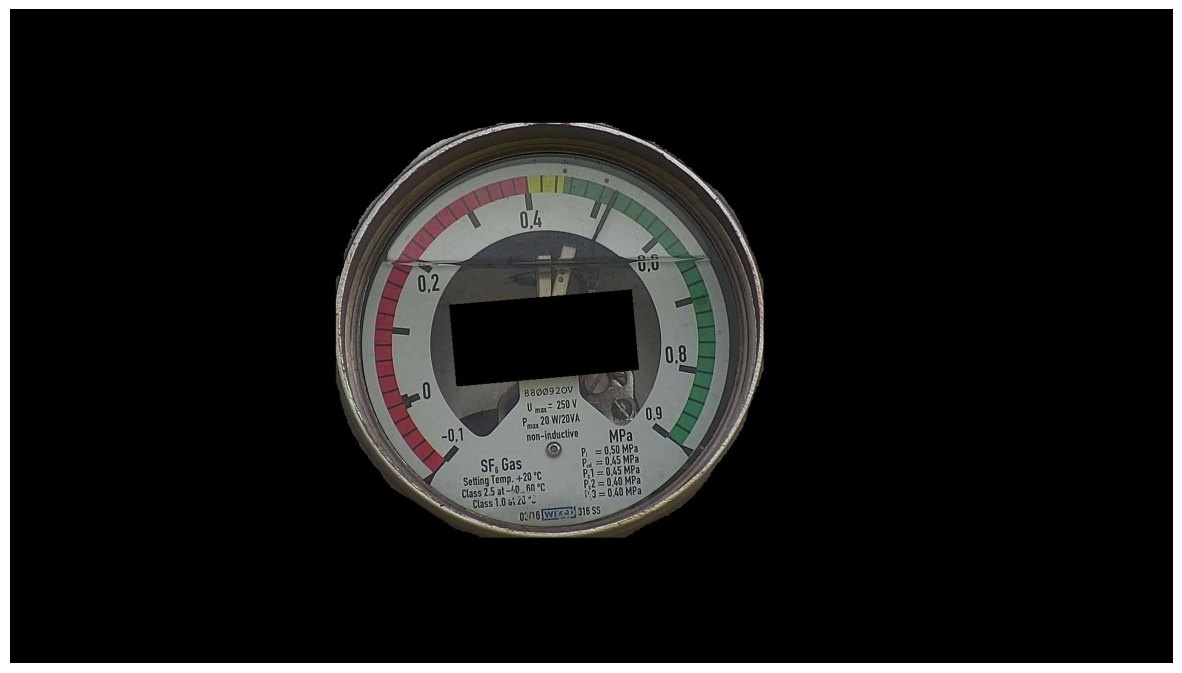

In [566]:
print(image.shape)
show_img(image)

刻度点拟合要求至少五个标注点

In [567]:
# 模板刻度点点集标注
# 图片坐标系

# candidate_point = [
#     (137,337), (121,183), (262,102), (396,195), (359,355)
# ]

# candidate_point = [
#     (866,497), (929,473), (990,460), (1050,455), (1109,458), (1171,470), (1233,494)
# ]
candidate_point = np.array([
    (700,766), 
    (624,659), (603,528), (647,403), (745,311), (851,276), 
    (981,292), (1086,361), (1152,472), (1160,601), 
    (1107,720)
], dtype=float)

# 为了表盘刻度区域不影响指针扫描 需要找到一块较干净的椭圆环型区域进行扫描
# zone_point定义为该环形区域中线上的一点 用于缩放椭圆
zone_point = (1046,679) 
zone_radius = 10 # 扫描区域半径

### 椭圆拟合

In [568]:
# 拟合函数：点到椭圆两焦点距离之和
def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters
    
    # Calculate the actual distances from the points to the two foci
    sum_of_actual_distance = (
        np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2) +
        np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)
    )
    
    # Return the variance of the difference between actual and target distances
    return np.sum(((sum_of_actual_distance - sum_of_target_distance) ** 2) / (len(x_samples) - 1))

In [569]:
def fit_ellipse(x_samples, y_samples):


    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([np.mean(x_samples), np.mean(y_samples), np.mean(x_samples), np.mean(y_samples), 100])  # Initial focus points and target distance
    res_optimized = so.minimize(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))
    
    # 拟合结束后 通过焦点坐标得到 半长短轴、椭圆中心、长轴与x轴正半轴夹角 
    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x
        
        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)
        
        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)
        
        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt((l2_res / 2) ** 2 - (l_ab / 2) ** 2)  # Semi-minor axis length


        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:

        print('Fail to fit ellipse')
        return None

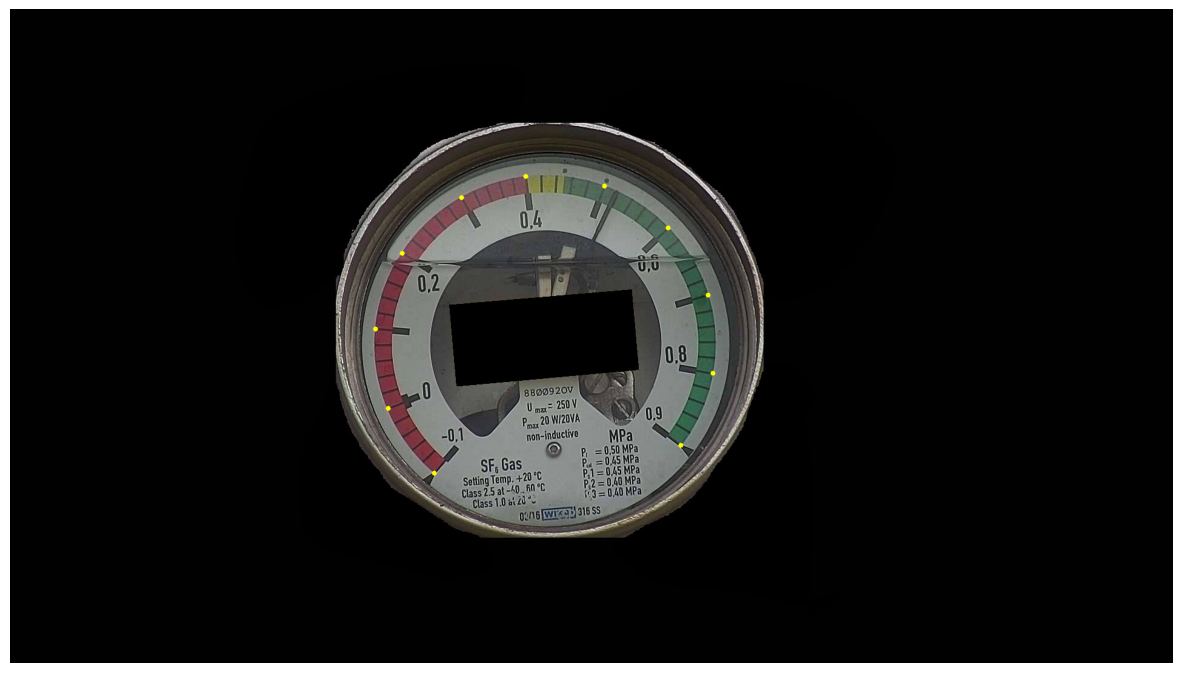

In [570]:
x_samples = candidate_point.T[0]
# 拟合过程前转换为直角坐标系（图像坐标系下的y是反的）
y_samples = image.shape[1] - candidate_point.T[1]

show_point(image, x_samples, y_samples)
# Fit the ellipse to the generated samples
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_samples, y_samples)

In [571]:

def get_Point_in_ellipse(h, k, a, b, alpha, theta):
    x = h + a * np.cos(alpha) * np.cos(theta) - b * np.sin(alpha) * np.sin(theta)
    y = k + a * np.cos(alpha) * np.sin(theta) + b * np.sin(alpha) * np.cos(theta)
    return x, y
# '''
# 当椭圆不仅需要平移，而且其长轴和短轴不与坐标轴平行时\会稍微复杂一些。此时，除了平移之外，还需要考虑旋转。假设椭圆中心位于点 \((h, k)\)，并且椭圆绕其中心旋转了一个角度 \(\theta\)（逆时针方向），那么椭圆的参数方程可以表示为：

# \[ x = h + a \cos(\theta) \cos(\alpha) - b \sin(\theta) \sin(\alpha) \]
# \[ y = k + a \cos(\theta) \sin(\alpha) + b \sin(\theta) \cos(\alpha) \]

# 这里：
# - \(a\) 是椭圆的半长轴。
# - \(b\) 是椭圆的半短轴。
# - \(theta\) 是参数，通常取值范围是从 \(0\) 到 \(2\pi\)。
# - \((h, k)\) 是椭圆中心的坐标。
# - \(\alpha\) 是椭圆长轴与正x轴之间的夹角。

# '''

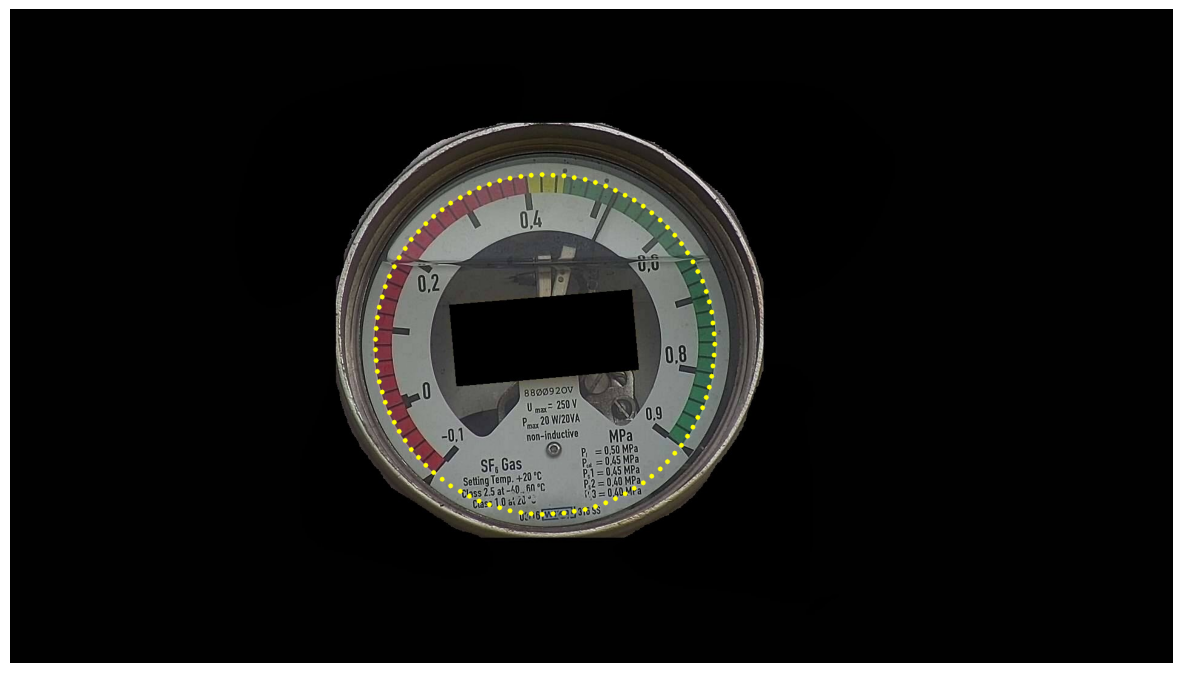

In [572]:
theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
x_res, y_res = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)

# 预览 检查椭圆曲线拟合
show_point(image, x_res, y_res)

椭圆缩放

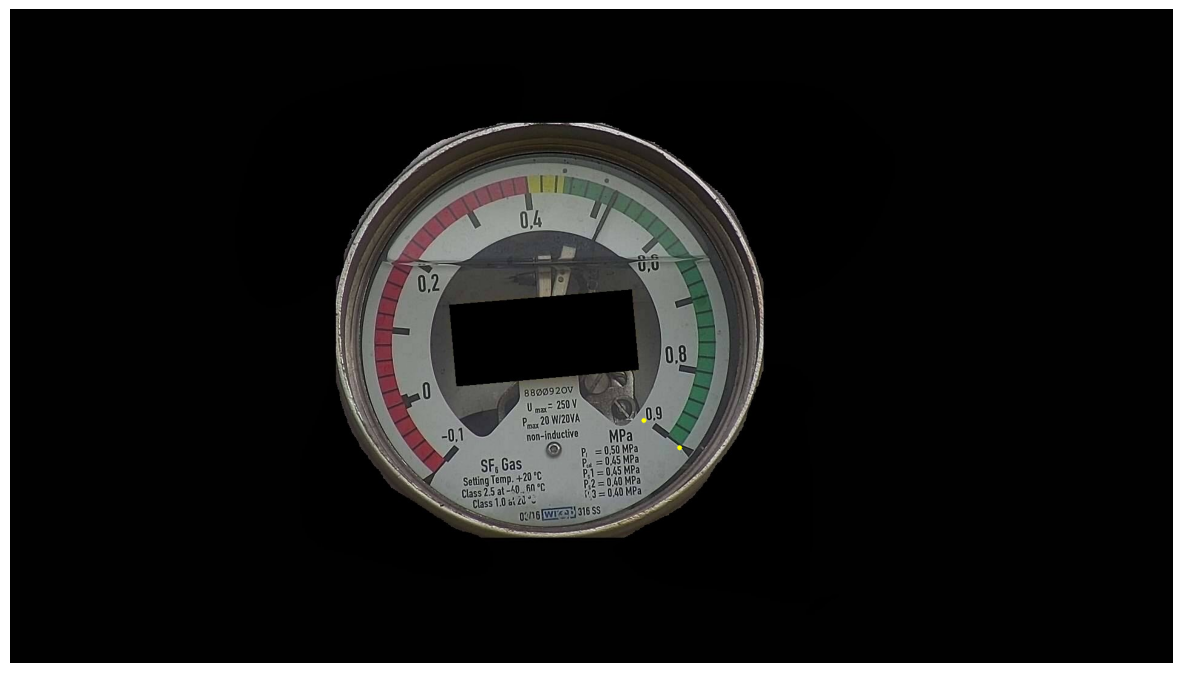

In [573]:
zone_point_x = zone_point[0]
zone_point_y = image.shape[1] - zone_point[1]

# 求出方向向量上在椭圆的坐标点
theta_zone_point_in_ellipse = np.arctan2(zone_point_y - y0, zone_point_x - x0)
point_in_ellipse_x, point_in_ellipse_y = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_zone_point_in_ellipse)

show_point( image, [point_in_ellipse_x, zone_point_x], [point_in_ellipse_y, zone_point_y] )

In [574]:
zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([point_in_ellipse_x, point_in_ellipse_y]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

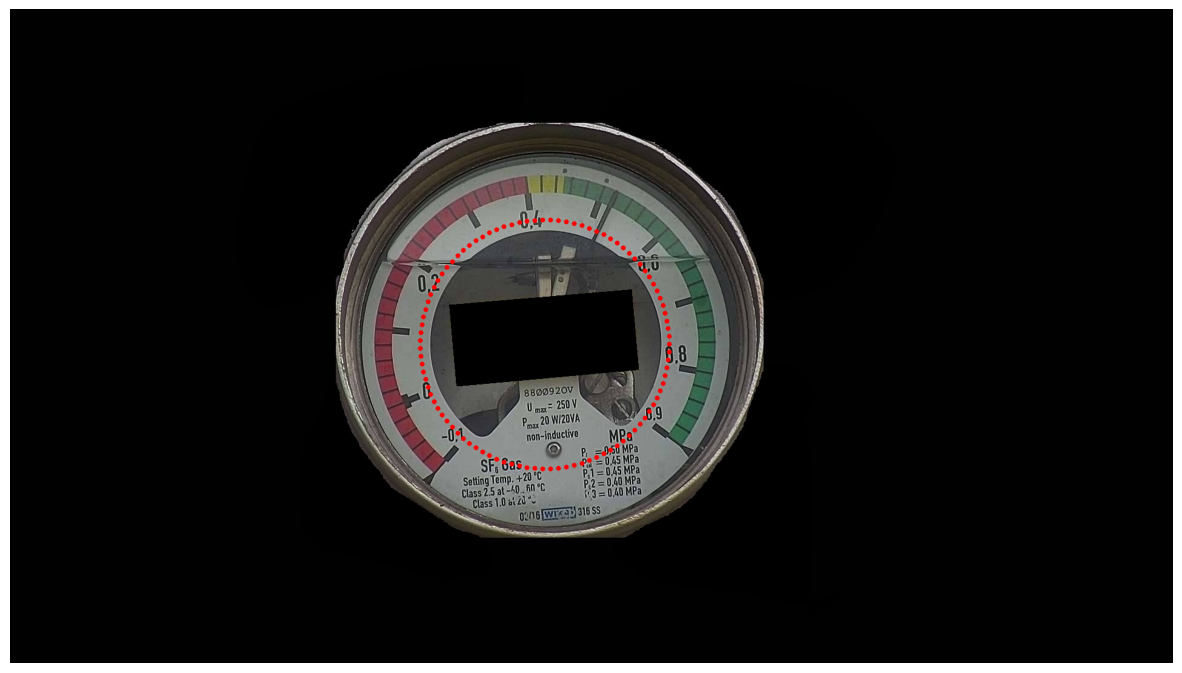

In [575]:
# 扫描区域 中线的椭圆
theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
x_zone, y_zone = get_Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_res)
show_point(image, x_zone, y_zone, (0,0,255))

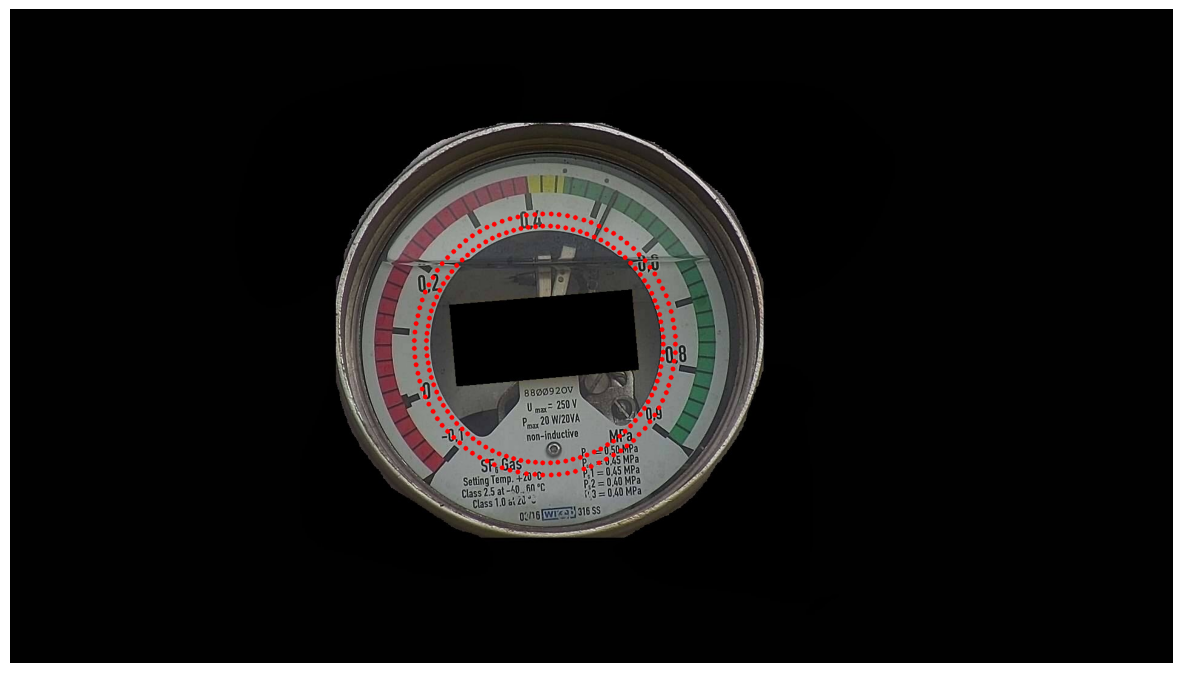

In [576]:
# 扫描区域可视化

s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = get_Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = get_Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(image, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))

虽然显示的是完整环形 但是实际扫描是从起点刻度到终点刻度的对应区域

## 计算刻度点坐标

In [577]:
# np.arctan2(y,x) 使用arctan2求弧度制夹角
# 第一象限 0 -> pi （逆时针）
# 第二象限 pi -> 2pi
# 第三象限 -2pi -> -pi
# 第四象限 -pi -> 0

In [578]:
# 刻度s到刻度t间 切分成separate_num份
# 返回左闭右开的点集序列
def separate_point(s_point, t_point, separate_num, keep_last_point=False):
    s_point_x, s_point_y = s_point[0], s_point[1]
    t_point_x, t_point_y = t_point[0], t_point[1]
    
    # # 两个相邻标点不应该超过90度
    theta_s = np.arctan2(s_point_y - y0, s_point_x - x0)
    theta_t = np.arctan2(t_point_y - y0, t_point_x - x0)
    if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
    
    # 切分出separate_num + 1个点
    theta_small_point = np.linspace(theta_s, theta_t, separate_num + 1)
    x_small, y_small = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_small_point)
    
    
    if not keep_last_point: 
        x_small = x_small[:-1]
        y_small = y_small[:-1]
    # 预览
    return x_small, y_small

第一次求解需要求解较小的、未标注出来的刻度点

定义x_samples、y_samples是从起点刻度到终点刻度，按顺时针方向排序的大刻度集合

若效果一般 应该标注所有刻度点（大小都标）并且跳过第一次求解

In [579]:
samples_num = len(x_samples)
x_samples_sep1, y_samples_sep1 = [], []

for i in range(1, samples_num):
    
    s_point = (x_samples[i - 1], y_samples[i - 1])
    t_point = (x_samples[i], y_samples[i])
    
    x_res, y_res = separate_point(s_point, t_point, 5, i == samples_num - 1 )
    x_samples_sep1.extend( x_res )
    y_samples_sep1.extend( y_res )

x_samples_sep1 = np.array(x_samples_sep1)
y_samples_sep1 = np.array(y_samples_sep1)

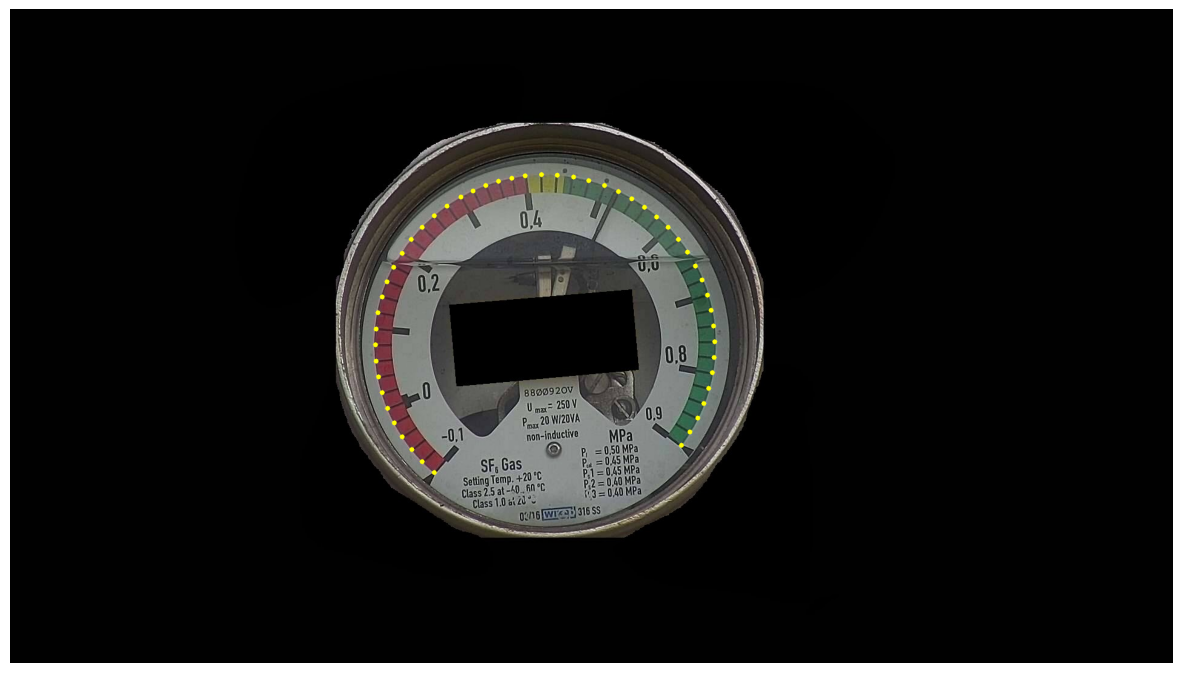

In [580]:
x_samples, y_samples = x_samples_sep1, y_samples_sep1
show_point(image, x_samples, y_samples)

第二次求解需要求出估读部分的刻度点 

一般默认把所有刻度点之间切分10份

由于后续读数算法的要求 我们需要在首尾各增加一个新刻度

保证每个需要进行读数的刻度前后都有10个刻度 用于计算切线


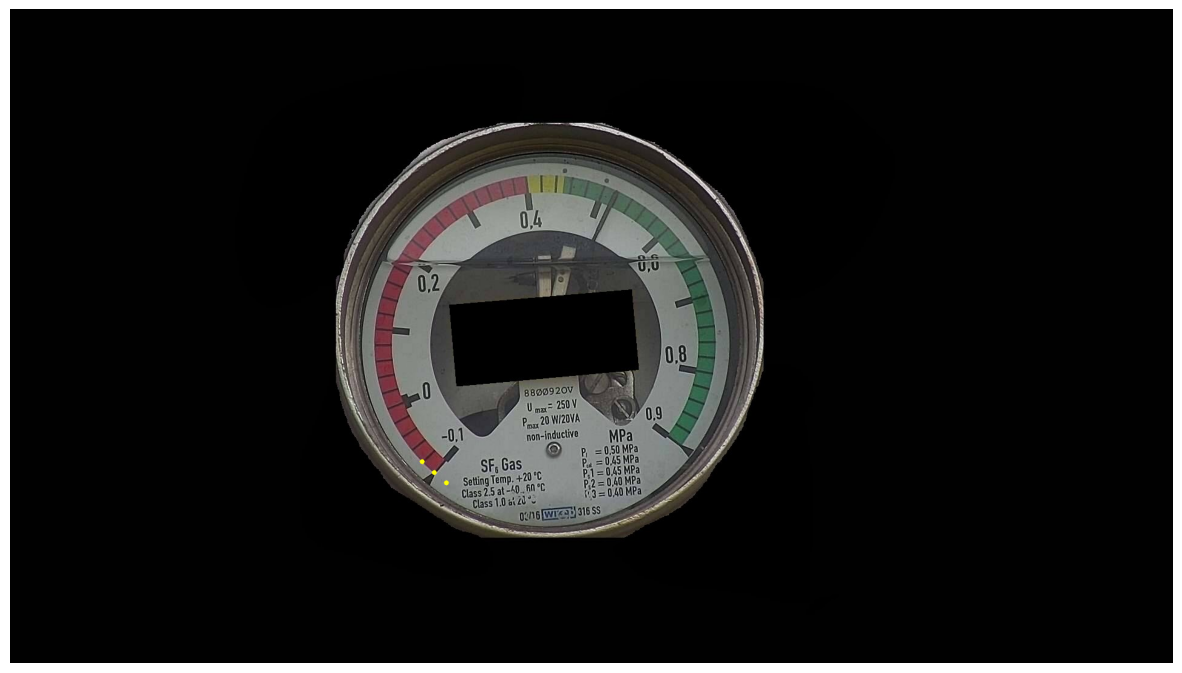

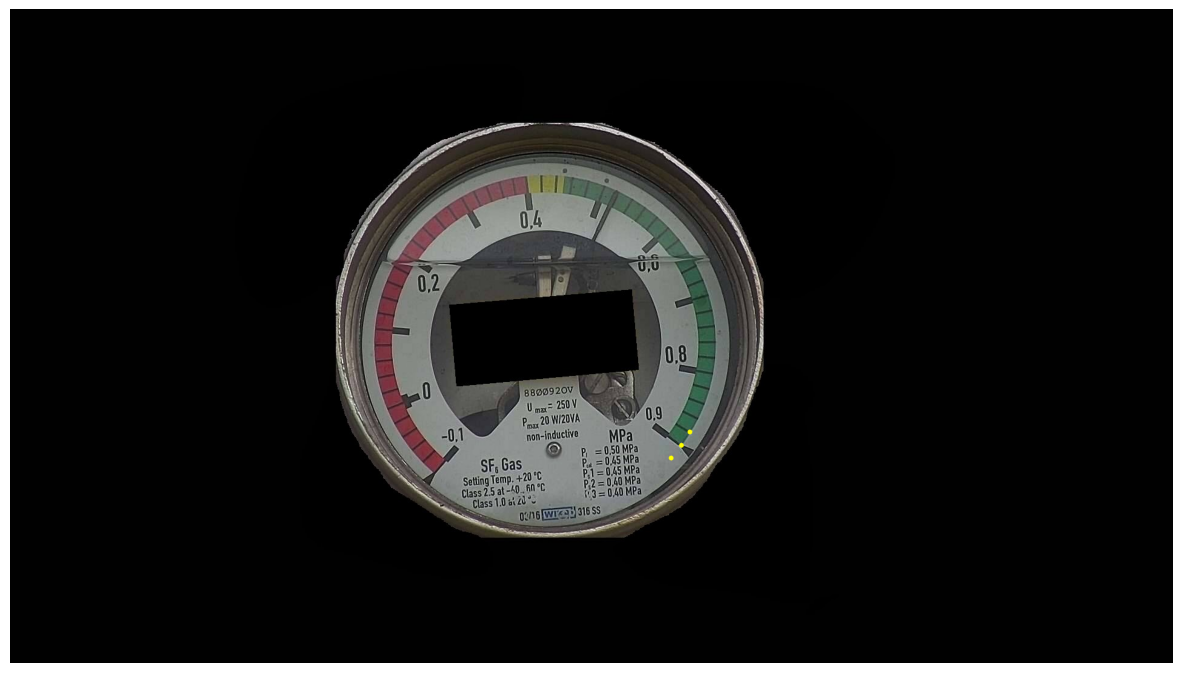

In [581]:
# 起点方向点
theta_s = np.arctan2(y_samples[0] - y0, x_samples[0] - x0) # 第一个点
theta_t = np.arctan2(y_samples[1] - y0, x_samples[1] - x0) # 第二个点
if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
theta_newL = 2*theta_s - theta_t # theta_s是中点夹角

point_newx, point_newy = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, [theta_newL])
show_point( image, np.concatenate((point_newx,x_samples[:2])), np.concatenate((point_newy, y_samples[:2])))

## 添加到最前面
x_samples = np.concatenate((point_newx, x_samples))
y_samples = np.concatenate((point_newy, y_samples))

# 终点方向点
theta_s = np.arctan2(y_samples[-2] - y0, x_samples[-2] - x0) # 倒数第二个点
theta_t = np.arctan2(y_samples[-1] - y0, x_samples[-1] - x0) # 倒数第一个点
if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
theta_newL = 2*theta_t - theta_s # theta_t是中点夹角

point_newx, point_newy = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, [theta_newL])
show_point( image, np.concatenate((point_newx, x_samples[-2:])),  np.concatenate((point_newy,y_samples[-2:])) )

## 添加到最后面
x_samples = np.concatenate((x_samples, point_newx))
y_samples = np.concatenate((y_samples, point_newy))

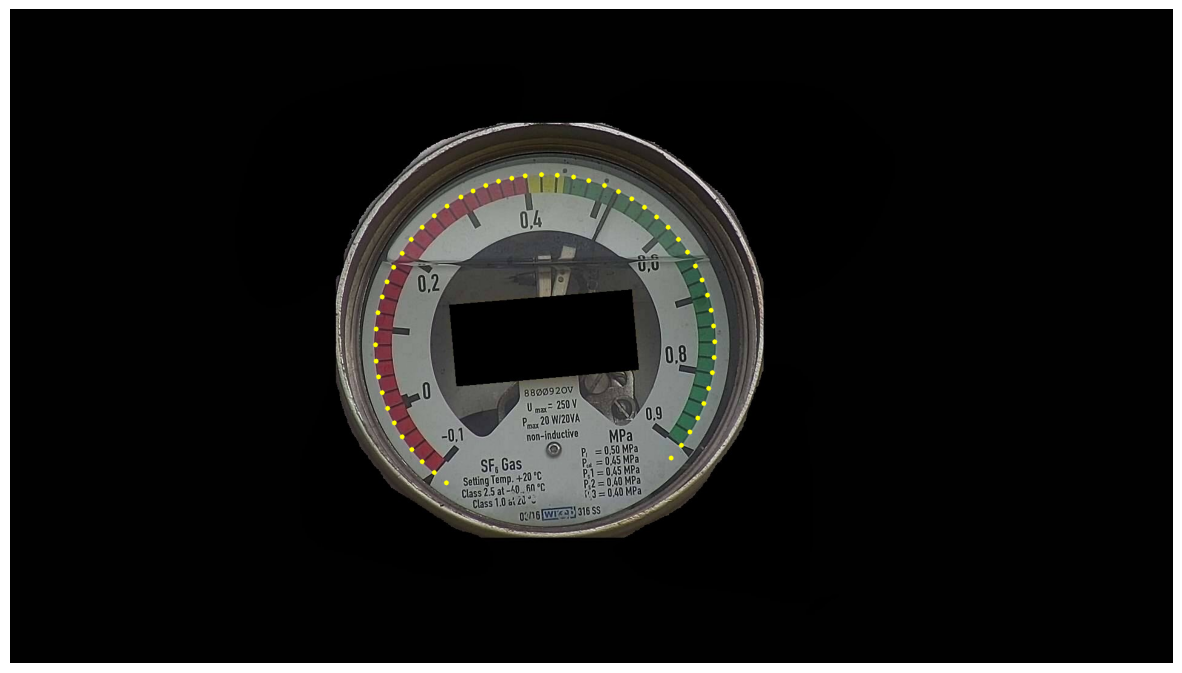

In [582]:
show_point(image, x_samples, y_samples)

In [583]:
# 切分估读区域
samples_num = len(x_samples)
x_samples_sep2, y_samples_sep2 = [], []

for i in range(1, samples_num):
    
    s_point = (x_samples[i - 1], y_samples[i - 1])
    t_point = (x_samples[i], y_samples[i])
    
    x_res, y_res = separate_point(s_point, t_point, 10, keep_last_point= (i == samples_num - 1))
    x_samples_sep2.extend( x_res )
    y_samples_sep2.extend( y_res )

x_samples_sep2 = np.array(x_samples_sep2)
y_samples_sep2 = np.array(y_samples_sep2)

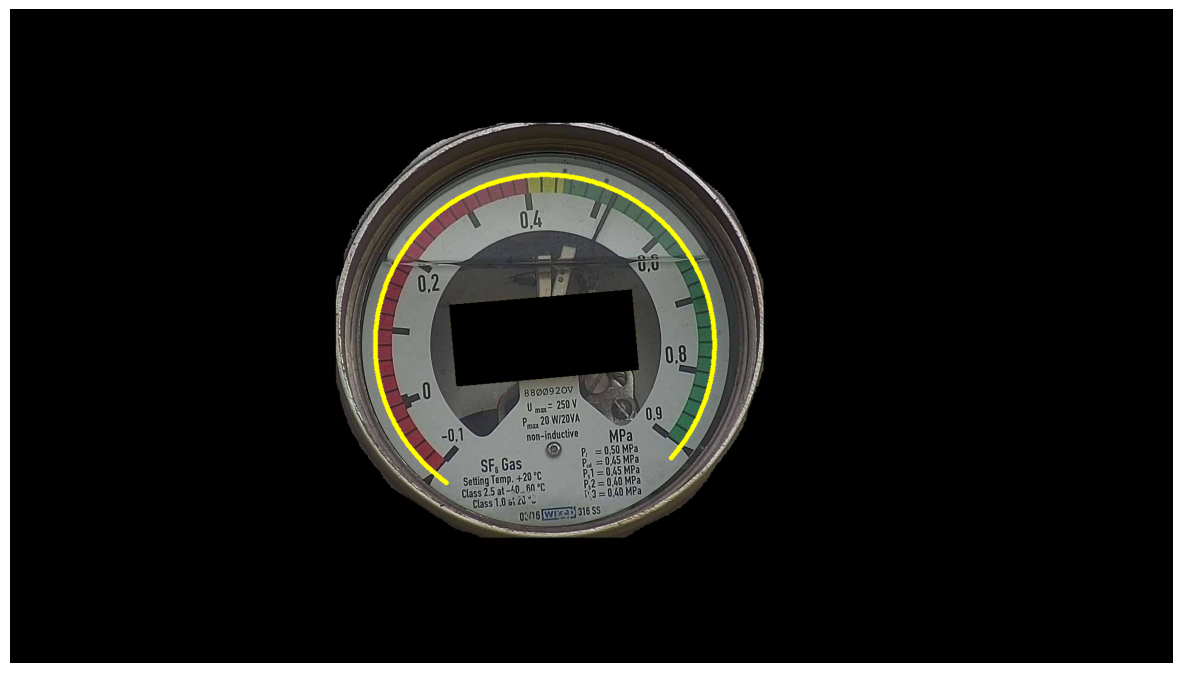

In [584]:
x_samples, y_samples = x_samples_sep2, y_samples_sep2
show_point(image, x_samples, y_samples)

接下来把点集移动到扫描区域中线即可

In [585]:

theta_samples = [
    np.arctan2(y_samples[i] - y0, x_samples[i] - x0)
    for i in range(len(x_samples))
]
x_res, y_res = get_Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_samples)
    

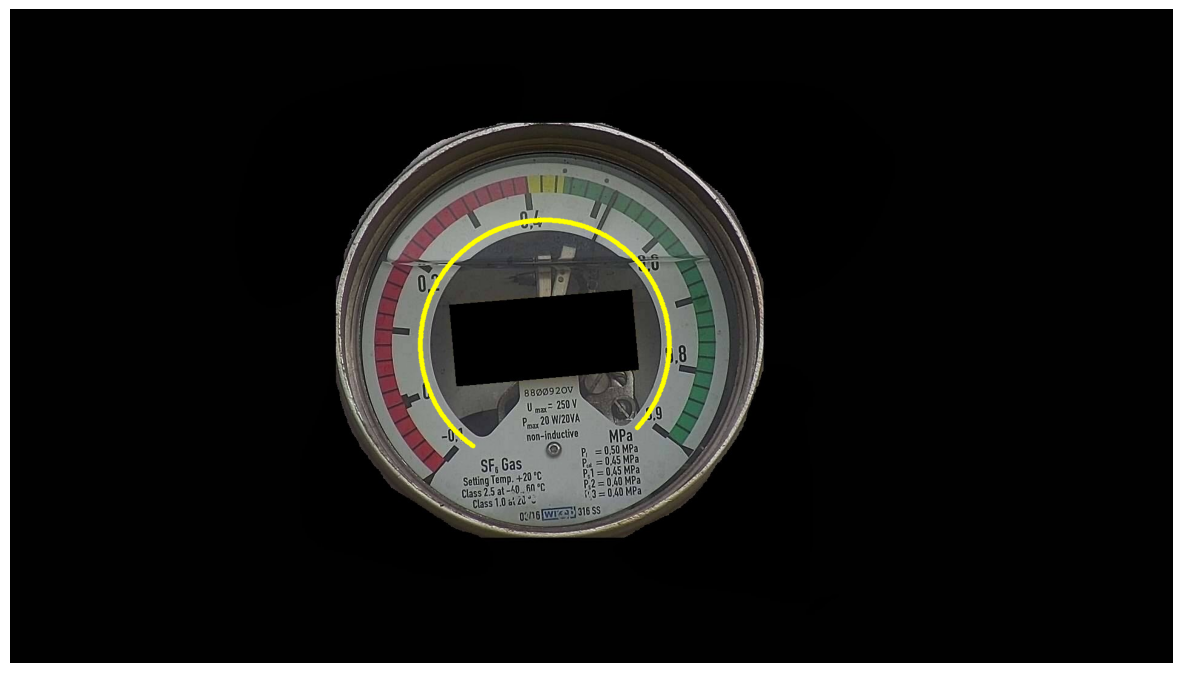

总共刻度点数 = 521


In [594]:
show_point(image, x_res, y_res)
print(f'总共刻度点数 = {len(x_res)}')

# 转换回图片坐标
candidate_point = np.array([x_res, image.shape[1] - y_res]).T

## 单应矩阵

In [595]:
template_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 转化为灰度图像
gray_img2 = cv2.cvtColor(cv2.imread('source/tv20171228143257TEVG5F.jpg'), cv2.COLOR_BGR2GRAY) # 需要识别的图片

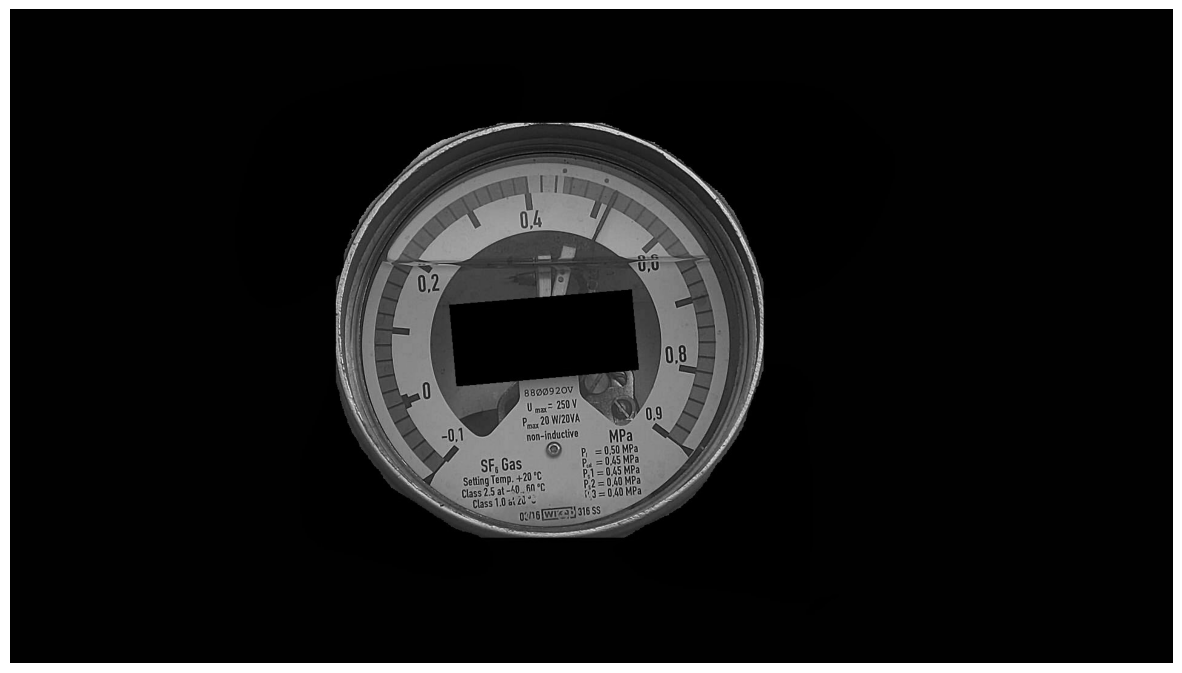

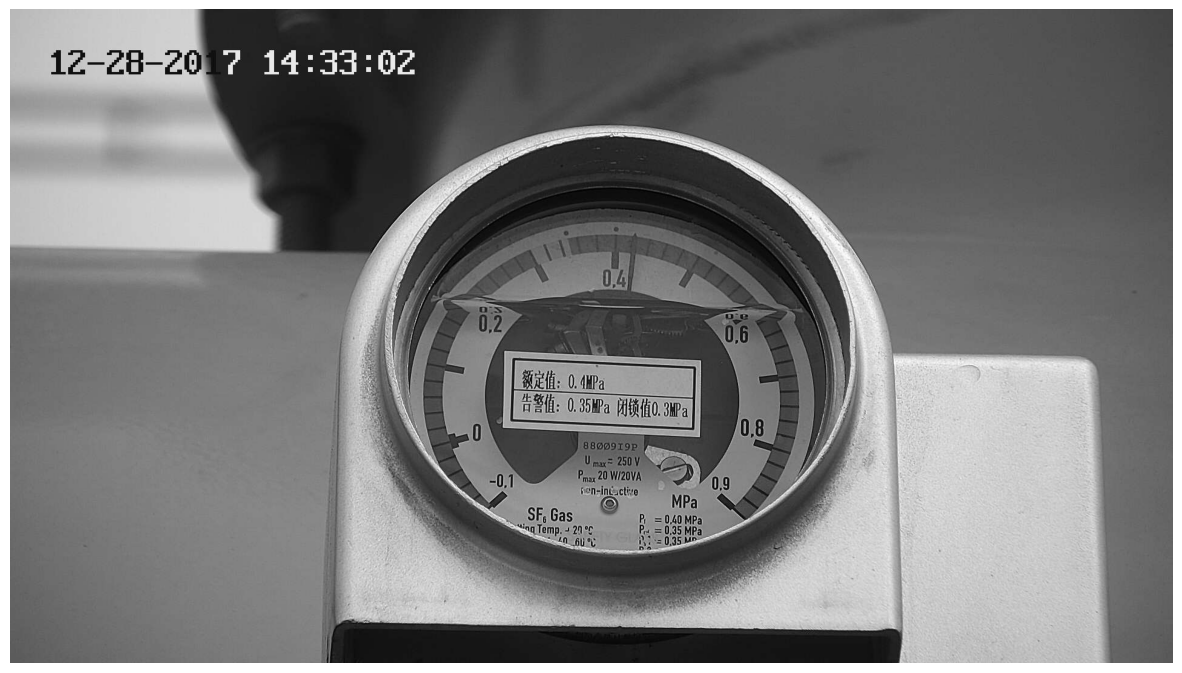

In [596]:
show_img(template_img)
show_img(gray_img2)

In [589]:
# AKAZE求解单应矩阵
def AKAZE4H(gray_img1, gray_img2):

    akaze = cv2.AKAZE_create()
    # 检测关键点和计算描述符
    keypoints1, descriptors1 = akaze.detectAndCompute(gray_img1, None)
    keypoints2, descriptors2 = akaze.detectAndCompute(gray_img2, None)

    # 使用 BFMatcher 匹配描述符
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # 按照距离将匹配结果排序
    matches = sorted(matches, key=lambda x: x.distance)

    # 只保留前300个匹配（可调整）
    good_matches = matches[:300]

    if len(good_matches) > 4:  # At least 4 points needed to compute homography
        # 获取匹配点的坐标
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # 计算单应矩阵
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # 可视化特征匹配
        height, width = gray_img2.shape
        warped_img = cv2.warpPerspective(gray_img1, H, (width, height))
        # Draw only inliers (matches used in homography)
        matches_mask = mask.ravel().tolist()
        draw_params = dict(matchColor=(0, 255, 0),  # Green color for inliers
                           singlePointColor=None,
                           matchesMask=matches_mask,  # Only draw inliers
                           flags=2)
        result_img = cv2.drawMatches(gray_img1, keypoints1, gray_img2, keypoints2, good_matches, None, **draw_params)
        show_img(result_img)

        return H
    else: 
        print("Not enough matches found to compute homography.")
        return None

In [597]:
def transform_candidate(candidate_point, gray_img1, gray_img2):

    # 求解单应
    H = AKAZE4H(gray_img1, gray_img2)
    if H is None: return None
    
    # 将模板点点集透视变化到目标图中
    candidate_projected_points = cv2.perspectiveTransform(candidate_point.reshape(-1,1,2), H)
    return candidate_projected_points.reshape(-1,2)

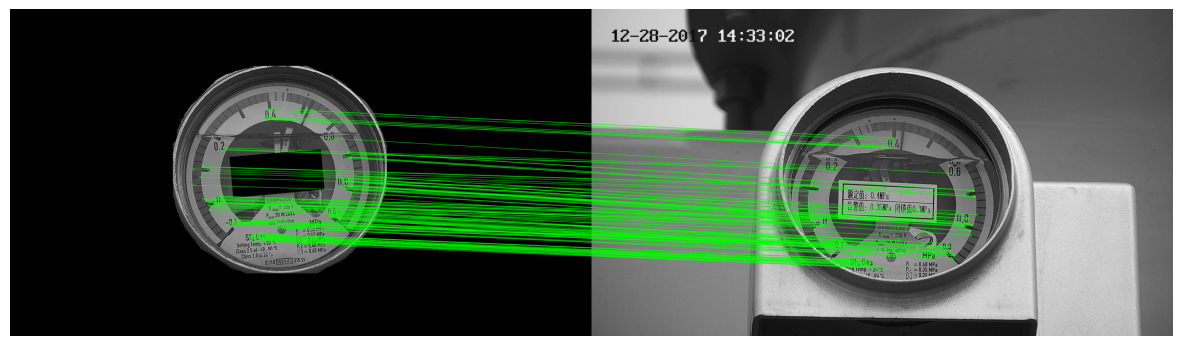

In [598]:
candidate_projected_points = transform_candidate(candidate_point, template_img, gray_img2)

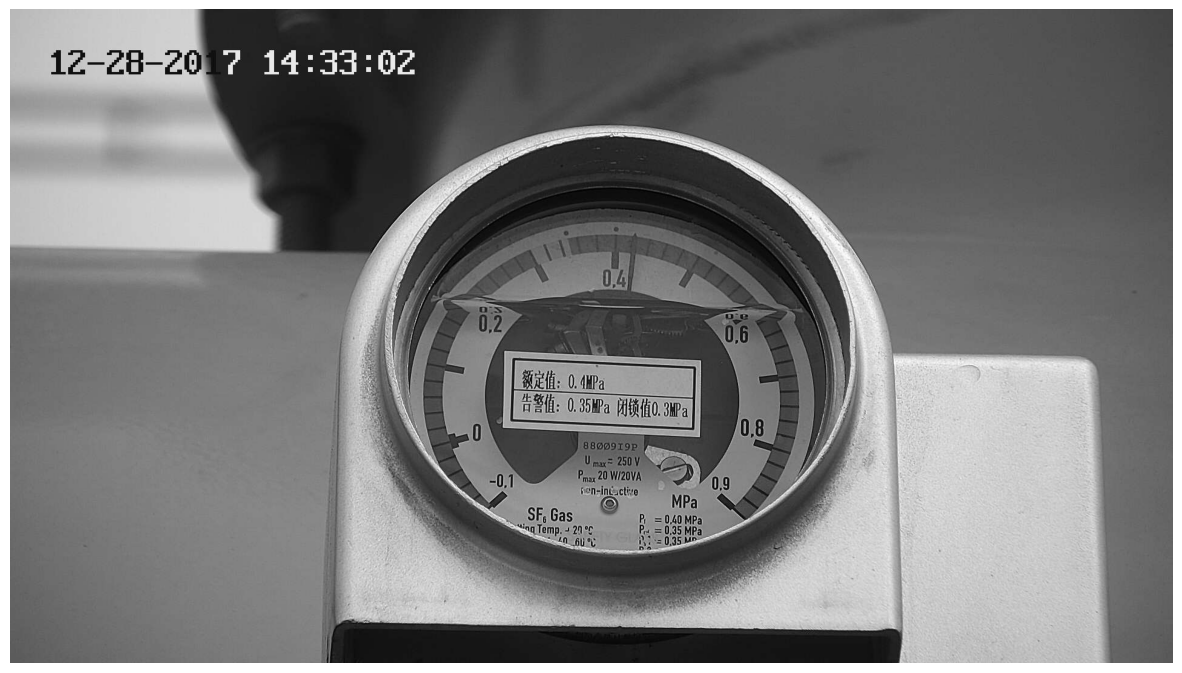

In [599]:
show_point(gray_img2, candidate_projected_points.T[0], candidate_projected_points.T[1], reversed=False)